In [1]:
%pylab inline
import numpy as np
import csv
from scipy import linalg
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def least_squares(A, b):
    return np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

In [3]:
# create n codes of length l, with lower and upper limits
def gen_code(n, l, lower, upper):
    x = []
    for i in range(n):
        x.append(np.random.randint(lower, upper, size=l))
    return x;

In [4]:
# generate some arbitrary y using the codes and randomized weights!
#returns y and the "solutions" for weights of codes and shifts
def generate_y_and_solutions(codes, shifting_on):
    y = np.zeros(l)
    code_weights, code_shifts = np.zeros(n), np.zeros(n) # use as answer key for comparison at the end!
    if shifting_on:
        for i in range(n):
            code_weights[i] = np.random.randint(-30, 30)/10
            code_shifts[i] = int(np.random.randint(0, l))
            codes[i] = np.roll(codes[i], int(code_shifts[i]))
            y += (code_weights[i])*codes[i]
    else: 
        for i in range(n):
            code_weights[i] = np.random.randint(-30, 30)/10
            y += (code_weights[i])*codes[i]
    return (y, code_weights, code_shifts)

In [5]:
def make_pretty_plots(y, l, n, codes, lower, upper, plot_codes, force_plot_codes):
    if plot_codes or force_plot_codes:
        plt.figure(figsize=(24, 6))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.stem(np.arange(0, l), codes[i],use_line_collection=True)
            plt.xlim([-0.5, l-0.5])
            plt.ylim([lower-1, upper+1])
            plt.xlabel("Amplitude")
            plt.ylabel("Time Step")
            plt.title("Code {}".format(i+1))

    plt.figure(figsize=(8, 4))
    plt.stem(np.arange(0, l), y,use_line_collection=True)
    plt.xlabel("(Combined) Amplitude")
    plt.ylabel("Time Step")
    plt.title("Received Signal y")

    plt.show()

In [6]:
# From here on, we can only use y (or err) and the source codes to find the weights and shifts!
# compute cross correlations of y (or err) with all songs
def correlations(vec, codes, iter_count, shifting_on):
    corrs = np.zeros((n, l))
    if shifting_on:
        for i in range(n):
            for lag in range(l):
                corrs[i][lag] = np.correlate(vec, np.roll(codes[i], lag))

        plt.figure(figsize=(24, 6))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.stem(np.arange(0, l), corrs[i],use_line_collection=True)
            plt.ylabel("Correlation")
            plt.xlabel("Lag (Time Steps)")
            if iter_count == 1:
                plt.title("Cross Correlation: y with code {}".format(i+1))
            else:
                plt.title("Cross Correlation: err with code {}".format(i+1))

        plt.show()
    else:
        for i in range(n):
            for lag in np.zeros(l):
                corrs[i][int(lag)] = np.correlate(vec, np.roll(codes[i], int(lag)))
        
        curr_corrs = []
        for i in range(n):
            curr_corrs.append(corrs[i][0])
    
        plt.figure(figsize=(24, 6))
        xint = range(1,n+1)

        plt.xticks(xint)
        plt.stem(np.arange(1, n+1), curr_corrs,use_line_collection=True)
        plt.xlabel("Correlation")
        plt.ylabel("Code Number")
        if iter_count == 1:
            plt.title("Cross Correlation: y with codes")
        else:
            plt.title("Cross Correlation: err with codes")

        plt.show()
    return corrs

In [7]:
# Find index of max correlation (or simply the code with max corr, if unshifted)
# returns 3-tuple: max_val, code_num, index
def process_corrs(corrs):
    temp_corrs = np.abs(corrs)
    max_val = np.amax(temp_corrs)
    for i in range(n):
        if max_val in temp_corrs[i]:
            index = np.argmax(temp_corrs[i])
            code_num = i+1
    return (max_val, code_num, index)

In [8]:
# least_squares things with A_mat and recieved signal y, uses info = max_val, code_num, index
# returns weights, current_guess
def lst_sq_processing(A_mat, y, max_val, codes, code_num, index, prev_weights, iter_count):
    if (iter_count == 1):
        A_mat = np.roll(codes[code_num-1], index)
        weights = (1/(A_mat.T.dot(A_mat)))*(A_mat.T).dot(y)
        current_guess = np.array(A_mat * weights)
    else:
        A_mat = np.column_stack((A_mat, np.roll(codes[code_num-1], int(index))))
        weights = least_squares(A_mat, y)
        current_guess = np.array(A_mat @ weights)
    
    plt.figure()
    plt.stem(np.arange(0, l), current_guess,use_line_collection=True)

    markerline, stemlines, baseline = plt.stem(
        np.arange(0, l), y, linefmt='grey', markerfmt='D', use_line_collection=True)
    markerline.set_markerfacecolor('orange')
    markerline.set_markeredgecolor('orange')
    markerline.set_fillstyle('full')
    plt.stem(np.arange(0, l), y, linefmt='grey', markerfmt='D',use_line_collection=True)
    
    plt.xlabel("Amplitude")
    plt.ylabel("Time Step")
    
    plt.legend(("Original Received Signal (y)", "Current reconstruction"))
    
    if iter_count == 1:
        plt.title("Best approximation after {} iteration".format(iter_count))
    else:
        plt.title("Best approximation after {} iterations".format(iter_count))
    
    return (weights, current_guess, A_mat)

In [9]:
def will_this_be_pretty(l, n):
    plot_codes = False
    if n > 8:
        return plot_codes
    if (l < 30 and n < 5) or (l < 90 and n < 4) or (l < 150 and n < 3): 
        plot_codes = True
            
    return plot_codes

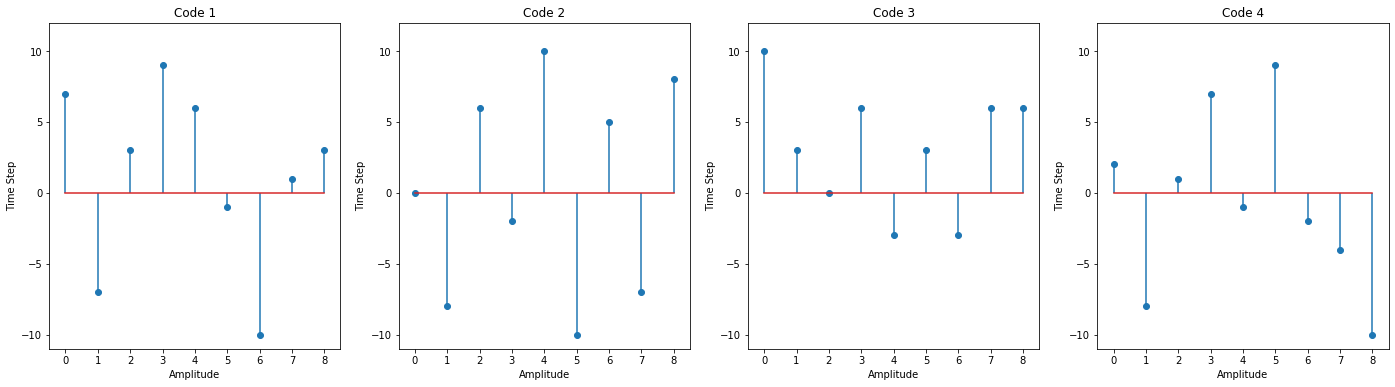

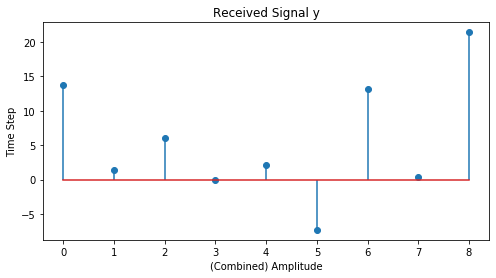

In [10]:
### PARAMETER: Change at will ###
shifting_on = False
### PARAMETERS: Change at will ###

### PARAMETERS: Change these at will ###
l = 9
n = 4

lower= -10 # bounds for code values
upper = 10
force_plot_codes = False # only change to True if you don't care too much about aesthetics in 
                         # plotting the generated codes :)
### PARAMETERS: Change these at will ###

plot_codes = will_this_be_pretty(l, n)

codes = gen_code(n, l, lower, upper+1)
y, code_weights, code_shifts = generate_y_and_solutions(codes, shifting_on)
make_pretty_plots(y, l, n, codes, lower, upper+1, plot_codes, force_plot_codes)

***Iteration count:  1 ***


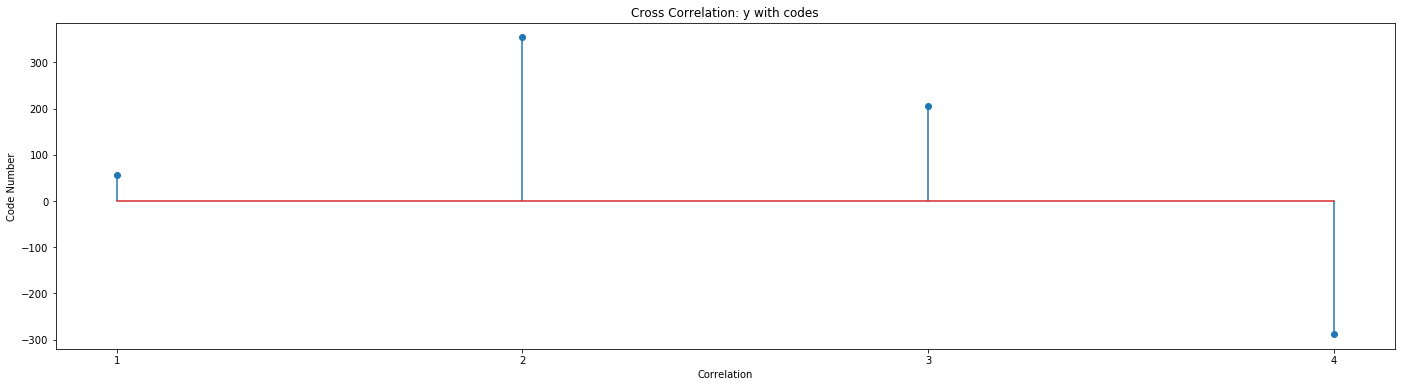

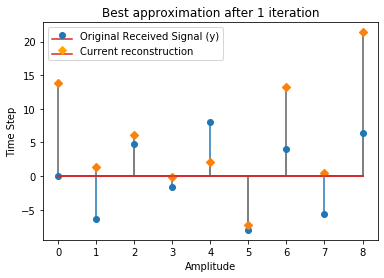

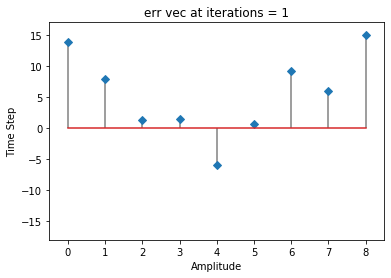

In [11]:
err = y
A_mat = np.zeros(l)
code_order = []
weights = 0
shifts = np.zeros(n)
scale_max = 0
counter = 0
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
#     print("info: ", max_val, code_num, index)
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess

    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.xlabel("Amplitude")
    plt.ylabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

***Iteration count:  2 ***


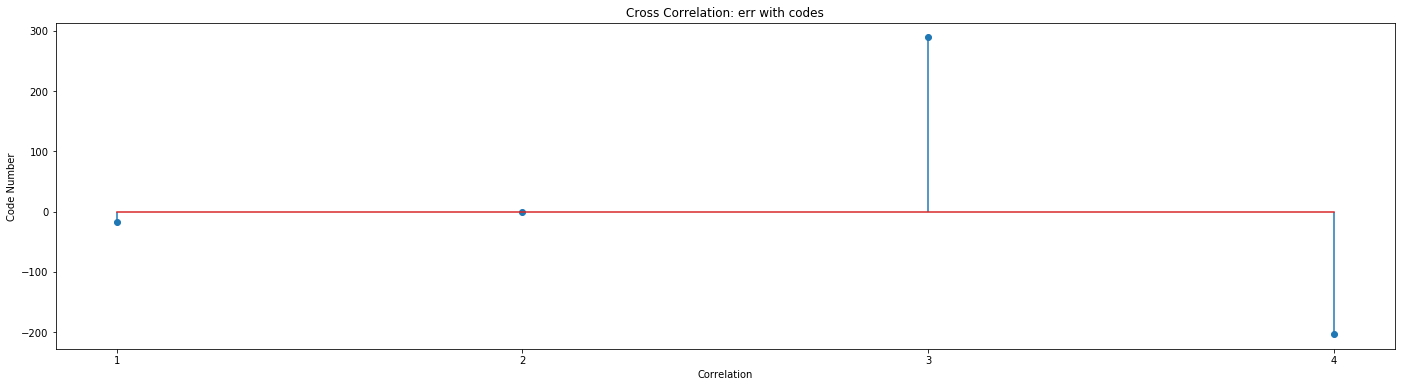

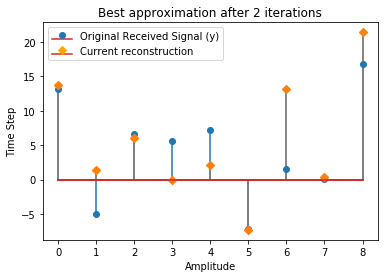

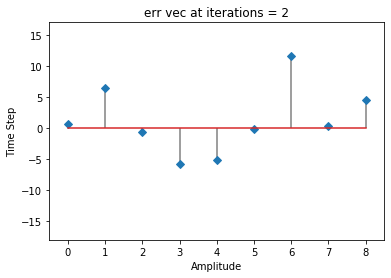

In [12]:
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
#     print("info: ", max_val, code_num, index)
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess

    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.xlabel("Amplitude")
    plt.ylabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

***Iteration count:  3 ***


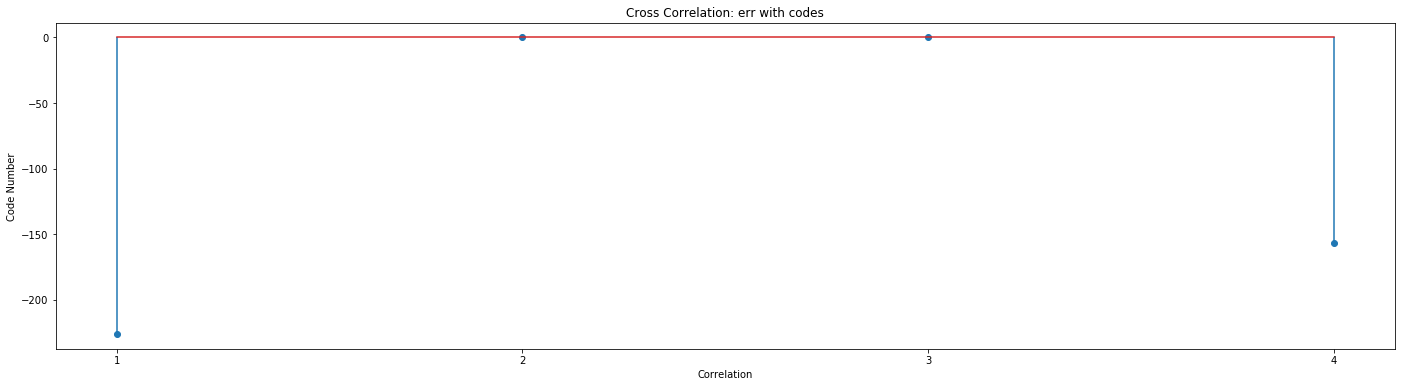

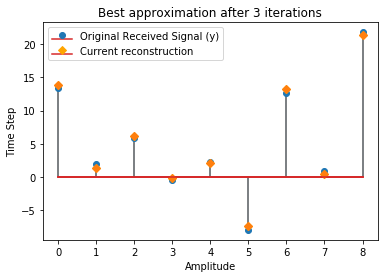

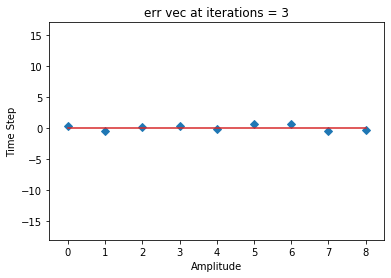

In [13]:
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
#     print("info: ", max_val, code_num, index)
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess

    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.xlabel("Amplitude")
    plt.ylabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

***Iteration count:  4 ***


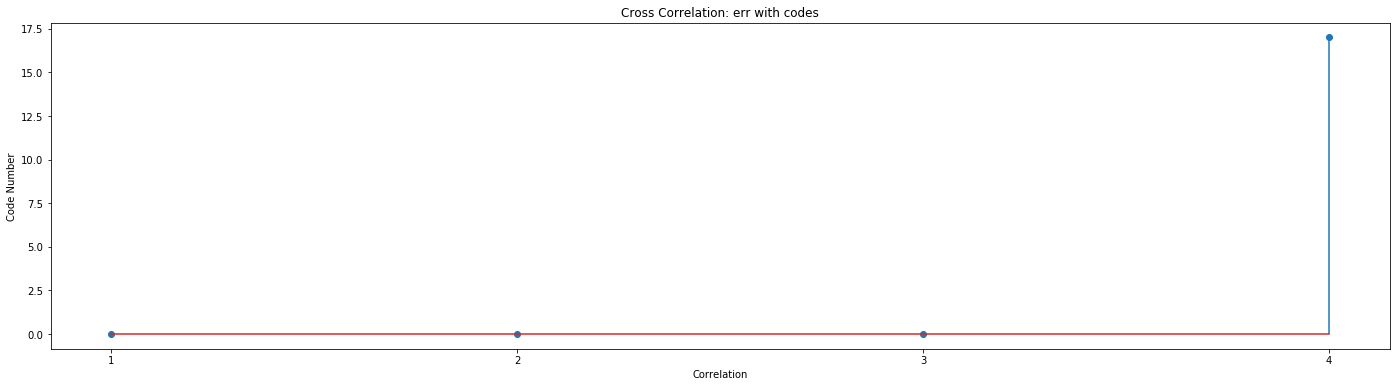

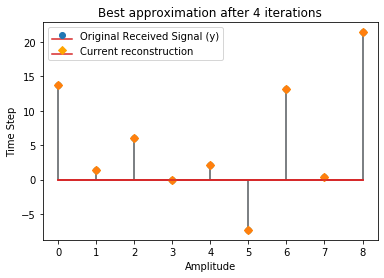

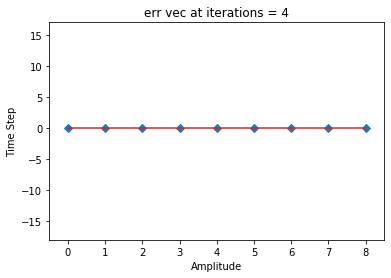

In [14]:
if ((np.linalg.norm(err) > 0.1) and counter < n):
    counter += 1
    print("***Iteration count: ", counter, "***")
    corrs = correlations(err, codes, counter, shifting_on)
    max_val, code_num, index = process_corrs(corrs) 
#     print("info: ", max_val, code_num, index)
    code_order.append(code_num)
    shifts[code_num-1] = index
    weights, current_guess, A_mat = lst_sq_processing(A_mat, y, max_val, codes, code_num, index, weights, counter)

    err = y - current_guess

    if counter == 1:
        scale_max = np.amax(np.abs(err)+2)

    plt.figure()
    plt.stem(np.arange(0, l), err, linefmt='grey', markerfmt='D', use_line_collection=True)
    plt.xlim([-0.5, l-0.5])
    plt.ylim([-scale_max-1, scale_max])
    plt.xlabel("Amplitude")
    plt.ylabel("Time Step")
    plt.title("err vec at iterations = {}".format(counter))

    plt.show()

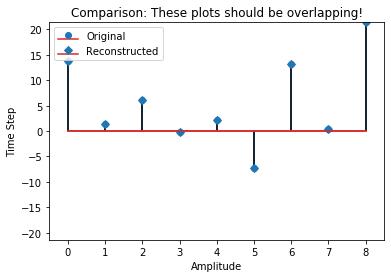

code weights:  [-1.2  1.6  2.2  0.1]
weights:  [ 1.6  2.2 -1.2  0.1]


In [15]:
#plot reconstructed signal alongside y
result_mine = np.zeros(l)
for i in range(n):
    if not isinstance(weights, type(0.4)) and len(weights) > i:
        val = np.multiply(weights[i], np.roll(codes[code_order[i]-1], int(shifts[code_order[i]-1])))
        result_mine += val

plt.figure()

plt.stem(np.arange(0, l), y, use_line_collection=True)

plt.stem(np.arange(0, l), result_mine, linefmt='black', markerfmt='D', use_line_collection=True)

plt.xlim([-0.5, l-0.5])
plt.ylim([-np.abs(max(np.amax(y), np.amax(result_mine))), np.abs(max(np.amax(y), np.amax(result_mine)))])
plt.xlabel("Amplitude")
plt.ylabel("Time Step")
plt.legend(("Original", "Reconstructed"))
plt.title("Comparison: These plots should be overlapping!")

if not np.allclose(result_mine, y, atol = 0.05):
    error_count += 1

plt.show()

print("code weights: ", code_weights)
print("weights: ", weights)